# Assignment 2 - Predictive Process Monitoring

**Due: Wednesday, 11 December, 2024 at 17:00 CET**

In this assignment, you will learn to train a regression model to predict the remaining time of a process. Additionally, you will demonstrate your ability to evaluate the model's performance and discuss the results in a report. The learning objectives of this assignment are to:

- Apply data cleaning, data transformation, and feature encoding techniques to preprocess event data.
- Use regression models to predict the remaining time of ongoing cases.
- Calculate model performance metrics (e.g., MAE, MSE, RMSE, \(R^2\), etc.).
- Refine the experimental design to compare the performance of different preprocessing and encoding methods.
- Reflect on the differences between various methods and their effect on the model performance.


## Tasks Overview

This assignment includes six tasks:

1. **Data Exploration:** Perform data exploration to understand the dataset.
2. **Data Preprocessing and Trace Encoding:** Apply data preprocessing and trace encoding (covered during Lectures 5 and 7).
3. **Regression Model Training:** Select a regression algorithm of interest and train a regression model (a regressor) to forecast the remaining time of each case after each event (see Lecture 6)
4. **Prefix-Length Buckets:** Create buckets of different prefix lengths and train a separate regressor for each bucket (covered during Lectures 5 and 7).
5. **Alternative Methods:** Revisit your design decisions and investigate two additional methods that may improve model performance.
6. **Evaluation:** Evaluate the results.

### Notes

- You may reuse your code from Tasks 2 and 3 in Tasks 4 and 5.
- For Task 6 and your report, ensure that you save all the calculated metrics (MAE, MSE, RMSE, and \(R^2\)) in previous tasks. Save these metrics in a list or dictionary to facilitate easy evaluation and comparison of results.




## Task 1: Exploring the data set



### Data set: Sepsis

Import the file *Complete Sepsis.csv* to load the Sepsis data set. This real-life event log contains events of sepsis cases from a hospital. Sepsis is a life threatening condition typically caused by an infection. One case represents a patient's pathway through the treatment process. The events were recorded by the ERP (Enterprise Resource Planning) system of the hospital. The original data set contains about 1000 cases with in total 15,000 events that were recorded for 16 different activities. Moreover, 39 data attributes are recorded, e.g., the group responsible for the activity, the results of tests and information from checklists. 

Additional information about the data can be found :
- https://data.4tu.nl/articles/dataset/Sepsis_Cases_-_Event_Log/12707639
- http://ceur-ws.org/Vol-1859/bpmds-08-paper.pdf




In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import data
# TODO: Change the file path to your file path
data_Sepsis = pd.read_csv("./Complete Sepsis.csv", sep=",")

# create an overview of the data
print(data_Sepsis.describe())
print(data_Sepsis.columns)
# print(data_Sepsis.head())

# Print the activities that occurred in the process
print(data_Sepsis['Activity'].unique())

# Print the cases (patients) that are following the process
# print(data_Sepsis['Case ID'].unique())

# for variable in data_Sepsis.columns:
#     print(variable)
#     print(data_Sepsis[variable].unique())

       Variant index         Age   Leucocytes          CRP   LacticAcid
count   13333.000000  777.000000  3075.000000  2884.000000  1281.000000
mean      360.079127   71.833977    12.985463   114.368585     1.902420
std       214.255001   15.573718    15.512797    86.366989     1.442281
min         1.000000   20.000000     0.200000     5.000000     0.200000
25%       176.000000   60.000000     7.700000    44.000000     1.100000
50%       360.000000   75.000000    10.900000    96.000000     1.500000
75%       547.000000   85.000000    15.000000   163.000000     2.200000
max       728.000000   90.000000   381.300000   573.000000    14.900000
Index(['Case ID', 'Activity', 'Complete Timestamp', 'Variant', 'Variant index',
       'lifecycle:transition', 'org:group', 'InfectionSuspected',
       'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie',
       'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'Age',
       'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor'

### Create the Labels by Calculating the Remaining Time

To forecast the remaining time for each patient in the hospital, we group the events by patient, use the completion time of each patient (i.e., the timestamp of the last event for each patient), and calculate the time difference between the current event and the completion time. This is done for each event. As a result, we now have our labels, which indicate how long a patient will remain in the treatment process for each event.

To help you get started, we created the target variable *remaining_time(days)* for you. 

In [2]:
df = data_Sepsis.copy()

# ADDED BY US THIS IMPROVES ERROR A LOT, RETURN ER SEEMS TO BE WHEN A PATIENT HAS BEEN HOME FOR A LONG TIME, THEN RETURNS TO THE ER!
df = df[~df['Activity'].str.contains('Return ER')]

# Convert the timestamp column to datetime
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])

# Find the completion time for each case
completion_times = df.groupby('Case ID')['Complete Timestamp'].max().rename('completion_time')

# Merge completion time back into the original DataFrame
df = df.merge(completion_times, on='Case ID')

# Calculate the remaining time for each event
df['remaining_time'] = df['completion_time'] - df['Complete Timestamp']


# Calculate the remaining time for each event in days
df['remaining_time(days)'] = df['remaining_time'].dt.total_seconds()/60/60/24

# Retain rows where the remaining time is larger than 0 days. 
df = df[df['remaining_time(days)'] > 0]

# Drop the completion_time column to avoid information leakage
df = df.drop(columns=['completion_time'])

# Drop the remaining_time column to avoid information leakage
df = df.drop(columns=['remaining_time'])

# Display the result
label_column = 'remaining_time(days)'
# print(df['remaining_time(days)'].describe())

# Fill in the column names of case id, activity, and time stamps
column_Sepsis_CaseID = 'Case ID' 
column_Sepsis_Activity = 'Activity'
column_Sepsis_Timestamps = 'Complete Timestamp'


### 1.1 Exploratory data analysis

For the data set, create 2-3 figures/tables that help you understand the data 

Note that some of these variables are categorical variables and some are numberical. Additionally, some of the variables have missing values. Think/discuss how would you preprocess these variables.


Make sure to at least check each variable's data type and understand their distribution. 

*For creating data visualizations, you may consider using the matplot library and visit the [matplot gallery](https://matplotlib.org/stable/gallery/index.html) for inspiration (e.g., histograms for distribution, or heatmaps for feature correlation).*

In [3]:
# TODO: plot figure(s)
display(df)
df.describe()

,Case ID,Activity,Complete Timestamp,Variant,Variant index,lifecycle:transition,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,...,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,remaining_time(days)
0,A,ER Registration,2014-10-22 11:15:41,Variant 35,35,complete,A,True,True,True,...,False,True,A,False,True,True,NaN,NaN,NaN,11.166192
1,A,Leucocytes,2014-10-22 11:27:00,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN,11.158333
2,A,CRP,2014-10-22 11:27:00,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,11.158333
3,A,LacticAcid,2014-10-22 11:27:00,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,11.158333
4,A,ER Triage,2014-10-22 11:33:37,Variant 35,35,complete,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.153738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13012,KNA,CRP,2014-12-13 07:00:00,Variant 728,728,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.0,NaN,3.416667
13013,KNA,Leucocytes,2014-12-14 07:00:00,Variant 728,728,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.5,NaN,NaN,2.416667
13014,KNA,LacticAcid,2014-12-14 07:00:00,Variant 728,728,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,2.416667
13015,KNA,Leucocytes,2014-12-16 07:00:00,Variant 728,728,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.9,NaN,NaN,0.416667


,Complete Timestamp,Variant index,Age,Leucocytes,CRP,LacticAcid,remaining_time(days)
count,12242,12242.000000,776.000000,3065.000000,2879.000000,1279.000000,12242.000000
mean,2014-07-03 06:54:52.876899328,362.461281,71.810567,12.971321,114.317819,1.903284,9.225281
min,2013-11-07 08:18:29,1.000000,20.000000,0.200000,5.000000,0.200000,0.011111
25%,2014-03-30 18:23:13.249999872,181.000000,60.000000,7.700000,44.000000,1.100000,3.461192
50%,2014-06-30 07:30:00,363.000000,75.000000,10.900000,96.000000,1.500000,5.754196
75%,2014-10-10 19:12:37,549.000000,85.000000,15.000000,162.500000,2.200000,10.729308
max,2015-03-06 08:00:00,728.000000,90.000000,381.300000,573.000000,14.900000,114.363067
std,NaN,213.528077,15.570077,15.534283,86.393914,1.443177,12.154505


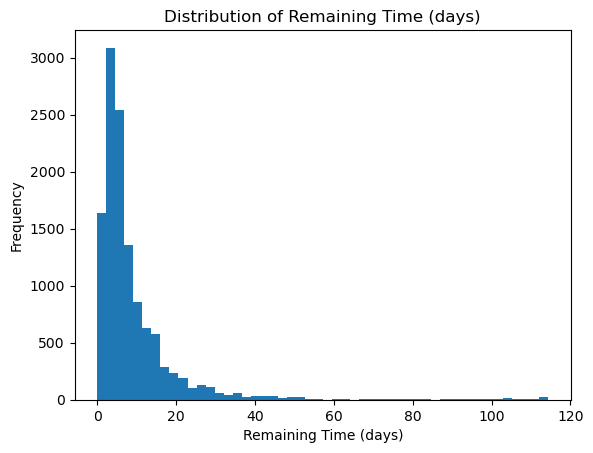

In [4]:
# remaining_time(days)
plt.hist(df["remaining_time(days)"], bins = 50)
plt.xlabel("Remaining Time (days)")
plt.ylabel("Frequency")
plt.title("Distribution of Remaining Time (days)")
plt.show()

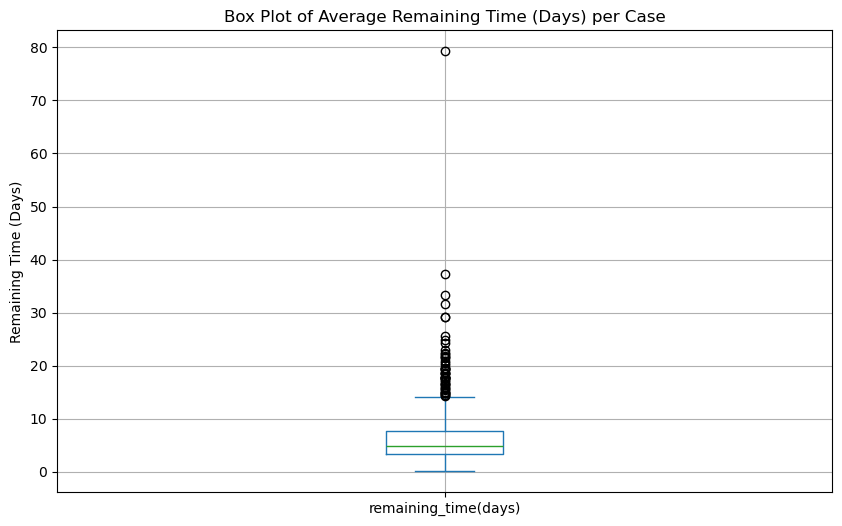

In [5]:
# Box Plot of Average Remaining Time (Days) per Case
plt.figure(figsize=(10, 6))
df.groupby('Case ID')['remaining_time(days)'].mean().plot(kind='box')
plt.title('Box Plot of Average Remaining Time (Days) per Case')
plt.ylabel('Remaining Time (Days)')
plt.grid(True)
plt.show()

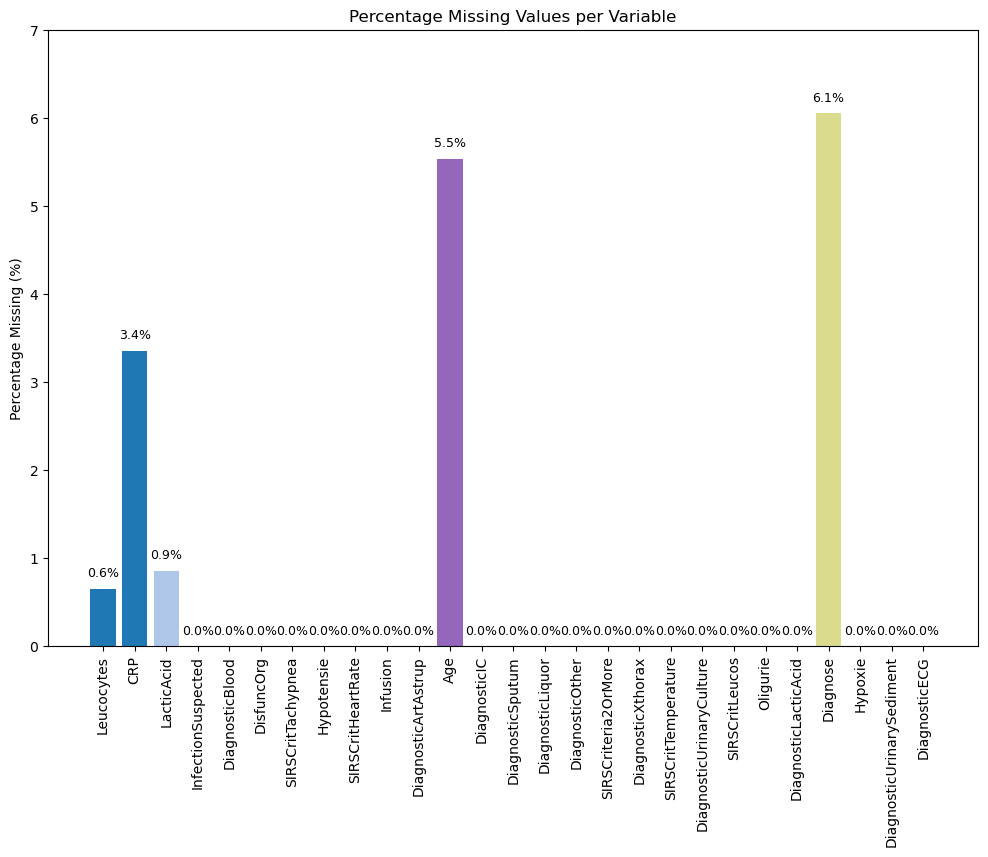

In [6]:
def calculate_percentage(df, activity, column):
    tempdf = df.copy()
    data = tempdf[tempdf['Activity'] == activity]
    total = len(data)
    nan_rows = data[column].isna().sum()
    return nan_rows / total * 100 if total > 0 else 0

# Variabelen en percentages
variables = [('Leucocytes', 'Leucocytes'), ('CRP', 'CRP'),('LacticAcid', 'LacticAcid'), ('ER Registration', 'InfectionSuspected'),
    ('ER Registration', 'DiagnosticBlood'),('ER Registration', 'DisfuncOrg'),('ER Registration', 'SIRSCritTachypnea'),('ER Registration', 'Hypotensie'),
    ('ER Registration', 'SIRSCritHeartRate'),('ER Registration', 'Infusion'),('ER Registration', 'DiagnosticArtAstrup'),('ER Registration', 'Age'),
    ('ER Registration', 'DiagnosticIC'),('ER Registration', 'DiagnosticSputum'), ('ER Registration', 'DiagnosticLiquor'),
    ('ER Registration', 'DiagnosticOther'),('ER Registration', 'SIRSCriteria2OrMore'),('ER Registration', 'DiagnosticXthorax'),
    ('ER Registration', 'SIRSCritTemperature'),('ER Registration', 'DiagnosticUrinaryCulture'),('ER Registration', 'SIRSCritLeucos'),
    ('ER Registration', 'Oligurie'),('ER Registration', 'DiagnosticLacticAcid'),('ER Registration', 'Diagnose'),('ER Registration', 'Hypoxie'),
    ('ER Registration', 'DiagnosticUrinarySediment'),('ER Registration', 'DiagnosticECG')
]

variablenames = [name for _, name in variables]


percentages = [calculate_percentage(df, activity, column) for activity, column in variables]

colors = plt.cm.tab20(np.linspace(0, 1, len(variables)))

# Grafiek maken
plt.figure(figsize=(12, 8))
bars = plt.bar(variablenames, percentages, color=colors)

# Labels en titel
plt.xticks(rotation=90)
plt.ylabel('Percentage Missing (%)')
plt.title('Percentage Missing Values per Variable')
plt.ylim(0, 7)

for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coördinaat
        bar.get_height() + 0.1,  # y-coördinaat, net boven de staaf
        f'{percentage:.1f}%',  # Tekstlabel met 1 decimaal
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.show()

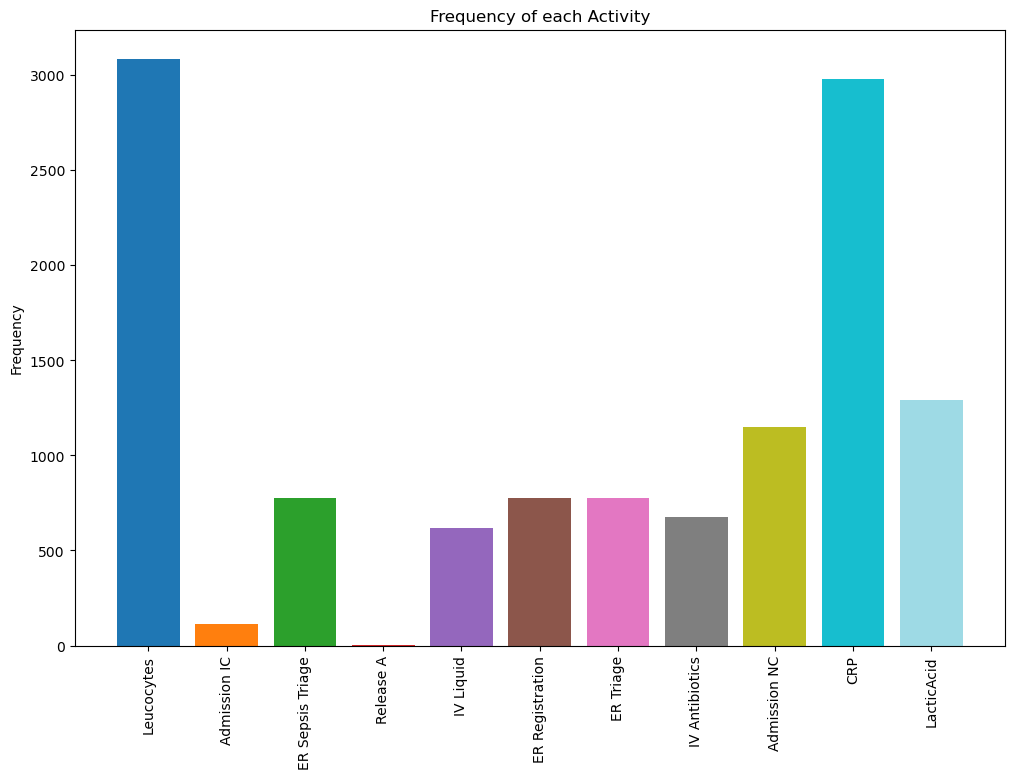

In [7]:
tempdf = df.copy()

activities = list(set(df['Activity']))
amounts = []
for activity in activities:
    data = df[df['Activity'] == activity]
    amounts.append(len(data))

colors = plt.cm.tab20(np.linspace(0, 1, len(activities)))

# Grafiek maken
plt.figure(figsize=(12, 8))
bars = plt.bar(activities, amounts, color=colors)

# Labels en titel
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Frequency of each Activity')

plt.show()

df = tempdf

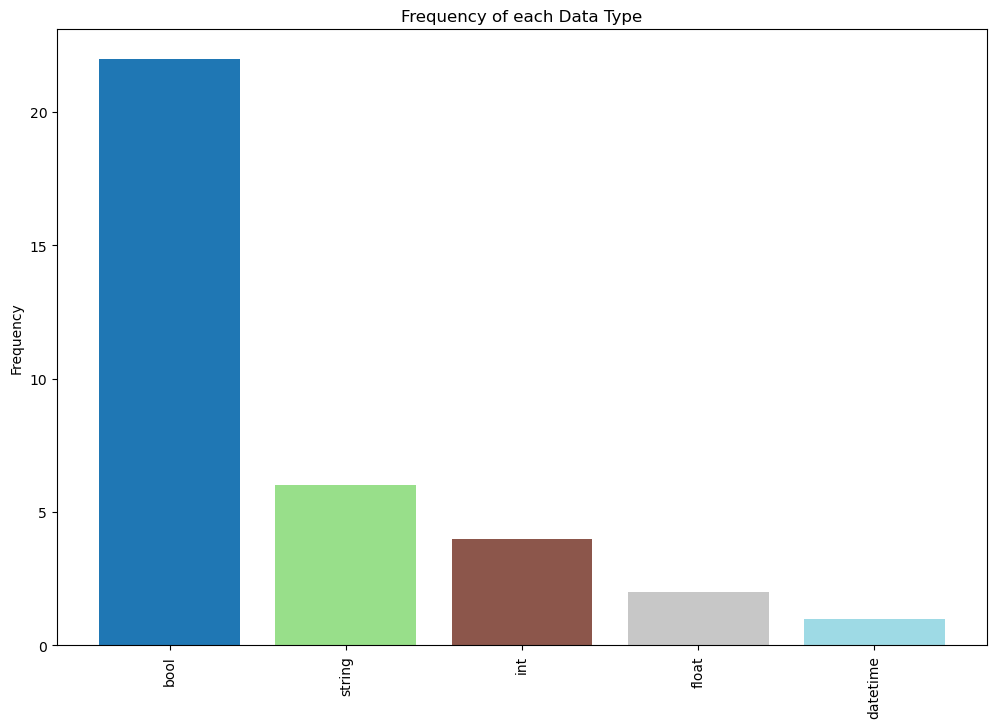

In [8]:
titles = ['bool', 'string', 'int', 'float', 'datetime']
values = [22, 6, 4, 2, 1]

colors = plt.cm.tab20(np.linspace(0, 1, len(titles)))

# Grafiek maken
plt.figure(figsize=(12, 8))
bars = plt.bar(titles, values, color=colors)

# Labels en titel
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Frequency of each Data Type')

plt.show()

## Task 2: Preprocessing and Trace Encoding

### 2.1 Data preprocessing

In the previous data exploration task, you gathered some initial insights about the dataset. Based on your observations during data exploration, decide which preprocessing steps are necessary (e.g., handling missing values, encoding categorical variables, scaling numerical features, etc.) and implement them accordingly.

In [9]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def bool_to_int(b):
    if isinstance(b, bool):
        return int(b)
    else:
        return b

def PreProcess(df, prevActivity=True):
    dfc = df.copy()
    # TODO: decide on how you handle missing values (ranging from dropping columns and dropping rows to filling in the empty cells) 
    # DATA CLEANING

    # Drop irrelevant columns:
    irr_columns = ["lifecycle:transition", "Variant", "Variant index"] 
    dfc = dfc.drop(irr_columns, axis=1)

    # Diagnose labels to nums
    lbl_enc_diag = LabelEncoder()
    lbl_enc_diag = lbl_enc_diag.fit(dfc["Diagnose"])
    dfc["Diagnose"] = lbl_enc_diag.transform(dfc["Diagnose"])

    # org:group to nums
    lbl_enc_org = LabelEncoder()
    lbl_enc_org = lbl_enc_org.fit(dfc["org:group"])
    dfc["org:group"] = lbl_enc_org.transform(dfc["org:group"])

    # Case IDs to nums
    lbl_enc_id = LabelEncoder()
    lbl_enc_id = lbl_enc_id.fit(dfc["Case ID"])
    dfc["Case ID"] = lbl_enc_id.transform(dfc["Case ID"])

    # Ensure every test event (Leucocytes, CRP, LacticAcid) has a score, if not drop all rows from that Case ID
    test_activities = ["Leucocytes", "CRP", "LacticAcid"]
    missing_score_check = (dfc["Activity"].isin(test_activities)) & (dfc[["Leucocytes", "CRP", "LacticAcid"]].isnull().all(axis=1))
    missing_scores_case_ids = dfc[missing_score_check]["Case ID"].unique()
    dfc = dfc[~dfc["Case ID"].isin(missing_scores_case_ids)]

    # Ensure ER Registration events have required columns filled, if not drop all rows from that Case ID
    registration_columns = ["InfectionSuspected", "DiagnosticBlood", "DisfuncOrg", "SIRSCritTachypnea", "Hypotensie", "SIRSCritHeartRate",
                            "Infusion", "DiagnosticArtAstrup", "Age", "DiagnosticIC", "DiagnosticSputum", "DiagnosticLiquor", "DiagnosticOther",
                            "SIRSCriteria2OrMore", "DiagnosticXthorax", "SIRSCritTemperature", "DiagnosticUrinaryCulture", "SIRSCritLeucos",
                            "Oligurie", "DiagnosticLacticAcid", "Diagnose", "Hypoxie", "DiagnosticUrinarySediment", "DiagnosticECG"]
    missing_regist_check = (dfc["Activity"] == "ER Registration") & (dfc[registration_columns].isnull().any(axis=1))
    er_registration_case_ids = dfc[missing_regist_check]["Case ID"].unique()
    dfc = dfc[~dfc["Case ID"].isin(er_registration_case_ids)]
    
    # Ensure that all activities without test scores / ER Registration values have all NaN in their respective columns, if not drop all rows belonging to that Case ID
    activities_with_value = ["Leucocytes", "CRP", "LacticAcid", "ER Registration"] 
    test_columns = ["Leucocytes", "CRP", "LacticAcid"]
    columns_that_should_have_no_value = registration_columns + test_columns
    
    activites_no_scores_check = (~dfc["Activity"].isin(activities_with_value)) & (dfc[columns_that_should_have_no_value].notna().all(axis=1))
    activities_should_not_have_values_case_ids = dfc[activites_no_scores_check]["Case ID"].unique()
    dfc = dfc[~dfc["Case ID"].isin(activities_should_not_have_values_case_ids)]
    
    # Outlier Removal, outdated after removing "Er Return", this function only removed 1 case.
    # Don't remove cause all results are already in the report.
    threshold = 70
    outlier_check = dfc["remaining_time(days)"] > threshold
    outlier_variants = dfc[outlier_check]["Case ID"].unique()
    dfc = dfc[~dfc["Case ID"].isin(outlier_variants)]

    ###############################################################################################################################################
    
    # TODO: perform data preprocessing steps 
    # DATA TRANSFORMATION

    # Convert TRUE/FALSE to 0/1
    dfc = dfc.map(bool_to_int)

    # Convert NaN to -1 / mean
    for col in ["Leucocytes", "CRP", "LacticAcid"]:
        dfc[col] = dfc[col].fillna(dfc[col].mean())

    dfc = dfc.fillna(-1)

    # Normalize
    scaler = MinMaxScaler()
    normalize_vars = ["Leucocytes", "CRP", "LacticAcid"]
    scaler.fit(dfc[normalize_vars])
    dfc[normalize_vars] = scaler.transform(dfc[normalize_vars])

    # Add previous activity to entry
    if prevActivity:
        dfc['prev_activity'] = np.roll(dfc["Activity"], 1)
        dfc.loc[dfc["Activity"] == "ER Registration", "prev_activity"] = None

    return dfc

dfc = PreProcess(df)
display(dfc)

,Case ID,Activity,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,remaining_time(days),prev_activity
0,0,ER Registration,2014-10-22 11:15:41,0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0,0.0,1.0,1.0,0.034857,0.213452,0.115689,11.166192,None
1,0,Leucocytes,2014-10-22 11:27:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.024665,0.213452,0.115689,11.158333,ER Registration
2,0,CRP,2014-10-22 11:27:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.031873,0.115689,11.158333,Leucocytes
3,0,LacticAcid,2014-10-22 11:27:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.136054,11.158333,CRP
4,0,ER Triage,2014-10-22 11:33:37,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.115689,11.153738,LacticAcid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13012,329,CRP,2014-12-13 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.551793,0.115689,3.416667,Admission NC
13013,329,Leucocytes,2014-12-14 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.021779,0.213452,0.115689,2.416667,CRP
13014,329,LacticAcid,2014-12-14 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.000000,2.416667,Leucocytes
13015,329,Leucocytes,2014-12-16 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,141,-1.0,-1.0,-1.0,0.022829,0.213452,0.115689,0.416667,LacticAcid


### 2.2 Trace Encoding


- Implement the aggregation encoding for the data set (for example, see [1], Table 6)

<span style="color:gray">[1] Ilya Verenich, Marlon Dumas, Marcello La Rosa, Fabrizio Maria Maggi, Irene Teinemaa:
Survey and Cross-benchmark Comparison of Remaining Time Prediction Methods in Business Process Monitoring. ACM Trans. Intell. Syst. Technol. 10(4): 34:1-34:34 (2019) [Section 1, 2, 4.1, 4.3, 4.6, 5.2, 5.3, 5.4, and 6] </span>

This encoding has been discussed during lecture 7.
- for the aggregation encoding check the pandas groupby.DataFrameGroupBy and cumsum function and read the [examples and answers on the stake overflow](https://stackoverflow.com/a/49578219)

In [10]:
# TODO: Implement the function that returns the aggregation state encoding of a log
def agg_per_event_encoding(dataFrame, columnCase, columnActivity, prevActivity=True):
    _new_data = dataFrame.copy()
    
    # TODO: Apply one-hot encoding to the 'activity' column
    onehot = pd.get_dummies(dataFrame[columnActivity], prefix="Activity", drop_first=True)
    _new_data = _new_data.join(onehot).drop(columnActivity, axis=1)
    # display(_new_data)
    
    if prevActivity:
        # PREV ACTIVITY
        onehot2 = pd.get_dummies(_new_data['prev_activity'], prefix="prevActivity", drop_first=True)
        _new_data = _new_data.join(onehot2).drop('prev_activity', axis=1)

    # TODO: Group by 'case id' and compute the cumulative sum for each activity
    cumulative_freq = _new_data.groupby(columnCase)[onehot.columns].cumsum()
    cumulative_freq.columns = [f"Cumulative_{col}" for col in onehot.columns]  
    
    # TODO: Concatenate the original DataFrame with the cumulative frequencies
    _data_with_features = pd.concat([_new_data, cumulative_freq], axis=1)

    # Remove Activity_ columns
    _data_with_features = _data_with_features.drop(columns=onehot.columns)

    return(_data_with_features)



# For the data set, apply the aggregated state encoding
data_Sepsis_ag = agg_per_event_encoding(dfc, column_Sepsis_CaseID, column_Sepsis_Activity) 
pd.set_option('display.max_columns', None)
display(data_Sepsis_ag)

,Case ID,Complete Timestamp,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,DiagnosticIC,DiagnosticSputum,DiagnosticLiquor,DiagnosticOther,SIRSCriteria2OrMore,DiagnosticXthorax,SIRSCritTemperature,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,remaining_time(days),prevActivity_Admission NC,prevActivity_CRP,prevActivity_ER Registration,prevActivity_ER Sepsis Triage,prevActivity_ER Triage,prevActivity_IV Antibiotics,prevActivity_IV Liquid,prevActivity_LacticAcid,prevActivity_Leucocytes,Cumulative_Activity_Admission NC,Cumulative_Activity_CRP,Cumulative_Activity_ER Registration,Cumulative_Activity_ER Sepsis Triage,Cumulative_Activity_ER Triage,Cumulative_Activity_IV Antibiotics,Cumulative_Activity_IV Liquid,Cumulative_Activity_LacticAcid,Cumulative_Activity_Leucocytes
0,0,2014-10-22 11:15:41,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,85.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0,0.0,1.0,1.0,0.034857,0.213452,0.115689,11.166192,False,False,False,False,False,False,False,False,False,0,0,1,0,0,0,0,0,0
1,0,2014-10-22 11:27:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.024665,0.213452,0.115689,11.158333,False,False,True,False,False,False,False,False,False,0,0,1,0,0,0,0,0,1
2,0,2014-10-22 11:27:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.031873,0.115689,11.158333,False,False,False,False,False,False,False,False,True,0,1,1,0,0,0,0,0,1
3,0,2014-10-22 11:27:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.136054,11.158333,False,True,False,False,False,False,False,False,False,0,1,1,0,0,0,0,1,1
4,0,2014-10-22 11:33:37,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.115689,11.153738,False,False,False,False,False,False,False,True,False,0,1,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13012,329,2014-12-13 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.551793,0.115689,3.416667,True,False,False,False,False,False,False,False,False,1,2,1,1,1,1,1,1,1
13013,329,2014-12-14 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.021779,0.213452,0.115689,2.416667,False,True,False,False,False,False,False,False,False,1,2,1,1,1,1,1,1,2
13014,329,2014-12-14 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.000000,2.416667,False,False,False,False,False,False,False,False,True,1,2,1,1,1,1,1,2,2
13015,329,2014-12-16 07:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.022829,0.213452,0.115689,0.416667,False,False,False,False,False,False,False,True,False,1,2,1,1,1,1,1,2,3


### 2.3 Create training and test data sets using temporal split


Choose the size of your test data and use that to find the appropiate date (time threshold) to split the dataset into training  and test set.

This approach is commonly used for time-series or event log data to ensure that training data comes from earlier time periods and test data from later periods. This avoids data leakage, where future data might influence the training process.

When writing your report, explain how you split the data and provide a justification for your choice as part of the experiment setup discussion.

In [11]:

# Define time threshold
time_threshold = pd.Timestamp('2014-10-20 00:00:00')

# Split the case 
def train_test_time_based_split(data_frame, time_threshold, column_case_var, column_activity, column_time_stamp, column_label):
    # TODO: Identify the start time of each case
    case_start_times = data_frame.groupby(column_case_var)[column_time_stamp].min().reset_index()
    
    # TODO: Separate case IDs into training and test sets
    train_vars = case_start_times[case_start_times[column_time_stamp] < time_threshold][column_case_var]
    test_vars = case_start_times[case_start_times[column_time_stamp] >= time_threshold][column_case_var]

    # TODO: Assign rows to training and test sets based on case IDs
    train_data = data_frame[data_frame[column_case_var].isin(train_vars)]
    test_data = data_frame[data_frame[column_case_var].isin(test_vars)]
 
    # TODO : Create the training and test sets, while dropping the irrelevant columns 
    drop_columns = [column_time_stamp, column_label]

    X_train = train_data.drop(drop_columns, axis=1)
    y_train = train_data[column_label]
    
    X_test = test_data.drop(drop_columns, axis=1)
    y_test = test_data[column_label]

    # Change the index(preprocess step, but moving it to preprocess function will break other code I don't want to change)
    y_train.index = X_train["Case ID"]
    X_train.index = X_train["Case ID"]
    X_train = X_train.drop("Case ID", axis=1)

    y_test.index = X_test["Case ID"]
    X_test.index = X_test["Case ID"]
    X_test = X_test.drop("Case ID",axis=1)

    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_time_based_split(
    data_Sepsis_ag, time_threshold, column_Sepsis_CaseID, 
    column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)
display(X_train)
print(len(X_test)/(len(X_train) + len(X_test)) * 100)

,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,DiagnosticIC,DiagnosticSputum,DiagnosticLiquor,DiagnosticOther,SIRSCriteria2OrMore,DiagnosticXthorax,SIRSCritTemperature,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,prevActivity_Admission NC,prevActivity_CRP,prevActivity_ER Registration,prevActivity_ER Sepsis Triage,prevActivity_ER Triage,prevActivity_IV Antibiotics,prevActivity_IV Liquid,prevActivity_LacticAcid,prevActivity_Leucocytes,Cumulative_Activity_Admission NC,Cumulative_Activity_CRP,Cumulative_Activity_ER Registration,Cumulative_Activity_ER Sepsis Triage,Cumulative_Activity_ER Triage,Cumulative_Activity_IV Antibiotics,Cumulative_Activity_IV Liquid,Cumulative_Activity_LacticAcid,Cumulative_Activity_Leucocytes
Case ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
61,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,55.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,12,0.0,1.0,1.0,0.034857,0.213452,0.115689,False,False,False,False,False,False,False,False,False,0,0,1,0,0,0,0,0,0
61,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.115689,False,False,True,False,False,False,False,False,False,0,0,1,0,1,0,0,0,0
61,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.213452,0.115689,False,False,False,False,True,False,False,False,False,0,0,1,1,1,0,0,0,0
61,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.039885,0.213452,0.115689,False,False,False,True,False,False,False,False,False,0,0,1,1,1,0,0,0,1
61,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.043825,0.115689,False,False,False,False,False,False,False,False,True,0,1,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.013907,0.213452,0.115689,False,False,False,False,False,False,False,True,False,0,4,1,1,1,1,1,4,5
203,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.009971,0.213452,0.115689,False,False,False,False,False,False,False,False,True,0,4,1,1,1,1,1,4,6
203,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,141,-1.0,-1.0,-1.0,0.034857,0.023904,0.115689,False,False,False,False,False,False,False,False,True,0,5,1,1,1,1,1,4,6


22.024681029073413


## Task 3: Predicting Case Remaining Time 


In this task, you will train a regression model (aka regressor) to predict case remaining time. 
You may choose the regression tree, the random forest regression, the kNN-regressor, or the MLP for regression. Very similar to how you have trained a classification model in Assignment 1, now perform the following steps to train a regression model. 

A) use the default values for the parameters to get a regressor on the training data. 
- [Regression Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

(OPTIONAL) use 5-fold cross-validation to tune the parameters. And create plots to show how the selected parameters affect the performance. 

B) select the best-performing regressor (e.g., the default one or the one that achieved the lowest error) and report the error measures (MAE, MSE, RMSE, R^2) of the fitted model on the test data. 

    
#### TIPS:
In case you decide to perform cross-validation, you are allowed to reuse some of your code from Assignment 1 or use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class (see an [example](https://www.dezyre.com/recipes/find-optimal-parameters-using-gridsearchcv-for-regression), but be aware that GridSearchSV does not return MAE or the other error measures (e.g., MSE, RMSE, R^2), you will need to update the scoring function)



c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_erro


Random Forest Regressor Performance:
Mean Squared Error (MSE): 54.4471
Root Mean Squared Error (RMSE): 7.3788
Mean Absolute Error (MAE): 4.8230
R-squared (R²): -0.2150
Train Mean Squared Error (MSE): 12.6634
Train Root Mean Squared Error (RMSE): 3.5586
Train Mean Absolute Error (MAE): 2.3043
Train R-squared (R²): 0.6539

Multi-Layer Perceptron (MLP) Regressor Performance:
Mean Squared Error (MSE): 49.0714
Root Mean Squared Error (RMSE): 7.0051
Mean Absolute Error (MAE): 4.9116
R-squared (R²): -0.0950
Train Mean Squared Error (MSE): 31.1022
Train Root Mean Squared Error (RMSE): 5.5769
Train Mean Absolute Error (MAE): 4.1771
Train R-squared (R²): 0.1500


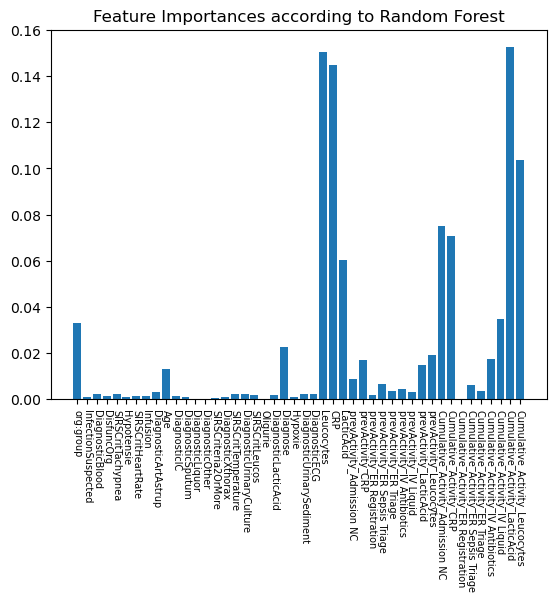

In [12]:
# TODO: import packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
try:
    from sklearn.metrics import root_mean_squared_error
except Exception:
    pass


def AllRegressing(X_train, y_train, X_test, y_test):
    seed = 1
    # RANDOMFOREST
    rf_regressor = RandomForestRegressor(random_state=seed)
    rf_regressor.fit(X_train, y_train)
    rf_predictions = rf_regressor.predict(X_test)
    rf_predictions_train = rf_regressor.predict(X_train)

    # MLP
    mlp_regressor = MLPRegressor(random_state=seed) 
    mlp_regressor.fit(X_train, y_train)
    mlp_predictions = mlp_regressor.predict(X_test)
    mlp_predictions_train = mlp_regressor.predict(X_train)


    # TODO: Evaluate the regressor on the test data and print the errors
    # RANDOM FOREST
    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)
    try:
        rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
    except TypeError:
        rf_rmse = root_mean_squared_error(y_test, rf_predictions)

    # TRAIN
    rf_mse_train = mean_squared_error(y_train, rf_predictions_train)
    rf_mae_train = mean_absolute_error(y_train, rf_predictions_train)
    rf_r2_train = r2_score(y_train, rf_predictions_train)
    try:
        rf_rmse_train = mean_squared_error(y_train, rf_predictions_train, squared=False)
    except TypeError:
        rf_rmse_train = root_mean_squared_error(y_train, rf_predictions_train)

    # MLP
    mlp_mse = mean_squared_error(y_test, mlp_predictions)
    mlp_mae = mean_absolute_error(y_test, mlp_predictions)
    mlp_r2 = r2_score(y_test, mlp_predictions)
    try:
        mlp_rmse = mean_squared_error(y_test, mlp_predictions, squared=False)
    except TypeError:
        mlp_rmse = root_mean_squared_error(y_test, mlp_predictions)

    # TRAIN
    mlp_mse_train = mean_squared_error(y_train, mlp_predictions_train)
    mlp_mae_train = mean_absolute_error(y_train, mlp_predictions_train)
    mlp_r2_train = r2_score(y_train, mlp_predictions_train)
    try:
        mlp_rmse_train = mean_squared_error(y_train, mlp_predictions_train, squared=False)
    except TypeError:
        mlp_rmse_train = root_mean_squared_error(y_train, mlp_predictions_train)

    print("\nRandom Forest Regressor Performance:")
    print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
    print(f"R-squared (R²): {rf_r2:.4f}")

    # TRAIN
    print(f"Train Mean Squared Error (MSE): {rf_mse_train:.4f}")
    print(f"Train Root Mean Squared Error (RMSE): {rf_rmse_train:.4f}")
    print(f"Train Mean Absolute Error (MAE): {rf_mae_train:.4f}")
    print(f"Train R-squared (R²): {rf_r2_train:.4f}")

    print("\nMulti-Layer Perceptron (MLP) Regressor Performance:")
    print(f"Mean Squared Error (MSE): {mlp_mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {mlp_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mlp_mae:.4f}")
    print(f"R-squared (R²): {mlp_r2:.4f}")

    # TRAIN
    print(f"Train Mean Squared Error (MSE): {mlp_mse_train:.4f}")
    print(f"Train Root Mean Squared Error (RMSE): {mlp_rmse_train:.4f}")
    print(f"Train Mean Absolute Error (MAE): {mlp_mae_train:.4f}")
    print(f"Train R-squared (R²): {mlp_r2_train:.4f}")

    # Plot the feature importances
    features = X_train.columns.tolist()
    plt.bar(features, rf_regressor.feature_importances_)
    plt.xticks(rotation=-90, fontsize=7)
    plt.title("Feature Importances according to Random Forest")
    plt.show()

    return mlp_predictions

mlp_predictions = AllRegressing(X_train, y_train, X_test, y_test)

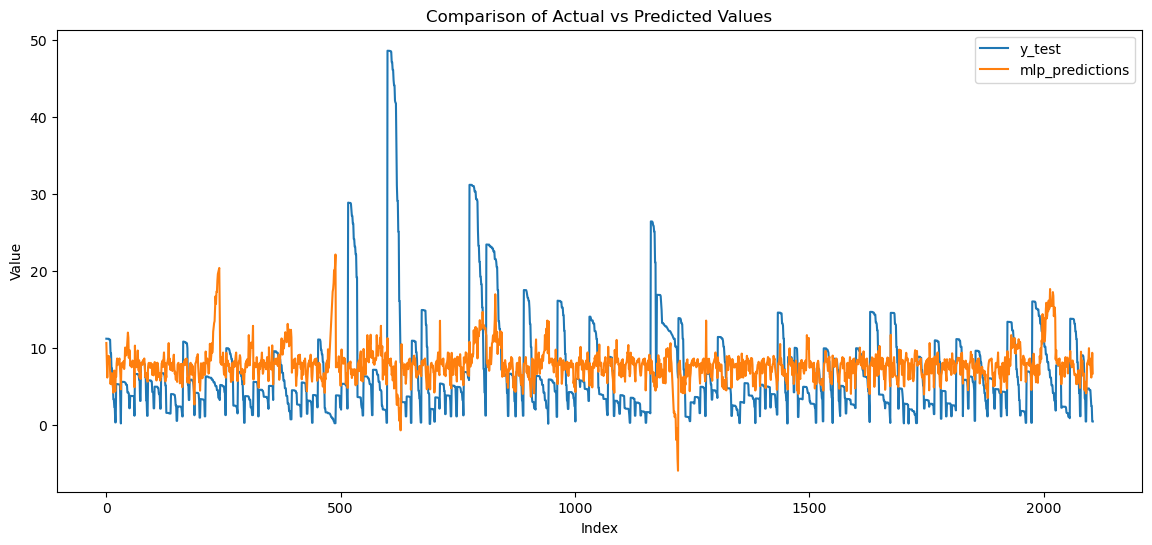

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label="y_test")
plt.plot(mlp_predictions, label="mlp_predictions")
plt.title("Comparison of Actual vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

## Task 4. Create three buckets and repeat Tasks 2 and 3 for each bucket. 

In this task, you will create three buckets, for prefix length 5, 10 and 15. For each of the bucket, repeat Task 2 and 3.  

You may use the functions you built for Tasks 2 and 3 or reuse code. 

Calculate the error measures (MAE, MSE, RMSE, R^2) and discuss the results. 

In [14]:
# Group by case_id and create a prefix column  
dfc2 = PreProcess(df)
dfc2['prefix'] = dfc2.groupby(column_Sepsis_CaseID).cumcount() + 1

# Buckets for prefix lengths 5, 10, and 15
buckets = {5: [], 10: [], 15:[]}

# TODO: Populate the buckets
for prefix_length in buckets.keys():
    # TODO: Populate the bucket with the events that have prefix <= prefix_length
    prefix_column = dfc2['prefix']
    buckets[prefix_length] = dfc2[prefix_column <= prefix_length]
    
for prefix_length, bucket_df in buckets.items():
    if not bucket_df.empty:
        
        # TODO: Apply the encoding
        bucket_df_Sepsis_ag = agg_per_event_encoding(bucket_df, column_Sepsis_CaseID, column_Sepsis_Activity)
        
        # TODO: Retain the event of prefix_length
        bucket_df_Sepsis_ag = bucket_df_Sepsis_ag[bucket_df_Sepsis_ag['prefix'] == prefix_length]
       
        # TODO: Create train-test split
        X_train, X_test, y_train, y_test = train_test_time_based_split(
            bucket_df_Sepsis_ag, time_threshold, column_Sepsis_CaseID, 
            column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)
     
        # TODO: Train a regression model (e.g., Random Forest Regressor) 
        # RANDOM FOREST
        seed=1
        reg = RandomForestRegressor(random_state = seed)
        reg.fit(X_train, y_train)
        rf_predictions = reg.predict(X_test)
        rf_predictions_train = reg.predict(X_train)

        # MLP
        mlp_regressor2 = MLPRegressor(random_state = seed) 
        mlp_regressor2.fit(X_train, y_train)
        mlp_predictions2 = mlp_regressor2.predict(X_test)
        mlp_predictions2_train = mlp_regressor2.predict(X_train)


        # TODO: Evaluate the regressor by calculating the MAE, etc...
        rf_mse = mean_squared_error(y_test, rf_predictions)
        rf_mae = mean_absolute_error(y_test, rf_predictions)
        rf_r2 = r2_score(y_test, rf_predictions)
        try:
            rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
        except TypeError:
            rf_rmse = root_mean_squared_error(y_test, rf_predictions)

        # TRAIN
        rf_mse_train = mean_squared_error(y_train, rf_predictions_train)
        rf_mae_train = mean_absolute_error(y_train, rf_predictions_train)
        rf_r2_train = r2_score(y_train, rf_predictions_train)
        try:
            rf_rmse_train = mean_squared_error(y_train, rf_predictions_train, squared=False)
        except TypeError:
            rf_rmse_train = root_mean_squared_error(y_train, rf_predictions_train)

        # MLP
        mlp_mse = mean_squared_error(y_test, mlp_predictions2)
        mlp_mae = mean_absolute_error(y_test, mlp_predictions2)
        mlp_r2 = r2_score(y_test, mlp_predictions2)
        try:
            mlp_rmse = mean_squared_error(y_test, mlp_predictions2, squared=False)
        except TypeError:
            mlp_rmse = root_mean_squared_error(y_test, mlp_predictions2)
        
        # TRAIN
        mlp_mse_train = mean_squared_error(y_train, mlp_predictions2_train)
        mlp_mae_train = mean_absolute_error(y_train, mlp_predictions2_train)
        mlp_r2_train = r2_score(y_train, mlp_predictions2_train)
        try:
            mlp_rmse_train = mean_squared_error(y_train, mlp_predictions2_train, squared=False)
        except TypeError:
            mlp_rmse_train = root_mean_squared_error(y_train, mlp_predictions2_train)
        
        
        # TODO: Print your results
        print(f"\nRandom Forest Regressor Performance bucket {prefix_length}:")
        print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
        print(f"R-squared (R²): {rf_r2:.4f}")
        
        # TRAIN
        print(f"Train Mean Squared Error (MSE): {rf_mse_train:.4f}")
        print(f"Train Root Mean Squared Error (RMSE): {rf_rmse_train:.4f}")
        print(f"Train Mean Absolute Error (MAE): {rf_mae_train:.4f}")
        print(f"Train R-squared (R²): {rf_r2_train:.4f}")

        print(f"\nMulti-Layer Perceptron (MLP) Regressor Performance bucket {prefix_length}:")
        print(f"Mean Squared Error (MSE): {mlp_mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {mlp_rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mlp_mae:.4f}")
        print(f"R-squared (R²): {mlp_r2:.4f}")

        # TRAIN
        print(f"Train Mean Squared Error (MSE): {mlp_mse_train:.4f}")
        print(f"Train Root Mean Squared Error (RMSE): {mlp_rmse_train:.4f}")
        print(f"Train Mean Absolute Error (MAE): {mlp_mae_train:.4f}")
        print(f"Train R-squared (R²): {mlp_r2_train:.4f}")

c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_erro


Random Forest Regressor Performance bucket 5:
Mean Squared Error (MSE): 46.2037
Root Mean Squared Error (RMSE): 6.7973
Mean Absolute Error (MAE): 4.4172
R-squared (R²): -0.1991
Train Mean Squared Error (MSE): 10.7986
Train Root Mean Squared Error (RMSE): 3.2861
Train Mean Absolute Error (MAE): 2.1424
Train R-squared (R²): 0.6287

Multi-Layer Perceptron (MLP) Regressor Performance bucket 5:
Mean Squared Error (MSE): 39.1373
Root Mean Squared Error (RMSE): 6.2560
Mean Absolute Error (MAE): 4.1739
R-squared (R²): -0.0158
Train Mean Squared Error (MSE): 28.4543
Train Root Mean Squared Error (RMSE): 5.3343
Train Mean Absolute Error (MAE): 3.8332
Train R-squared (R²): 0.0216


c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 


Random Forest Regressor Performance bucket 10:
Mean Squared Error (MSE): 48.7695
Root Mean Squared Error (RMSE): 6.9835
Mean Absolute Error (MAE): 4.6468
R-squared (R²): -0.2017
Train Mean Squared Error (MSE): 9.4143
Train Root Mean Squared Error (RMSE): 3.0683
Train Mean Absolute Error (MAE): 2.0239
Train R-squared (R²): 0.6959

Multi-Layer Perceptron (MLP) Regressor Performance bucket 10:
Mean Squared Error (MSE): 40.9595
Root Mean Squared Error (RMSE): 6.4000
Mean Absolute Error (MAE): 4.0342
R-squared (R²): -0.0093
Train Mean Squared Error (MSE): 29.9688
Train Root Mean Squared Error (RMSE): 5.4744
Train Mean Absolute Error (MAE): 3.5915
Train R-squared (R²): 0.0321

Random Forest Regressor Performance bucket 15:
Mean Squared Error (MSE): 78.8853
Root Mean Squared Error (RMSE): 8.8817
Mean Absolute Error (MAE): 5.9299
R-squared (R²): -0.1621
Train Mean Squared Error (MSE): 7.5405
Train Root Mean Squared Error (RMSE): 2.7460
Train Mean Absolute Error (MAE): 1.9656
Train R-squared (

c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_erro

## Task 5. Two Alternative Preprocessing and Encoding Methods

In this task, you will refine the design of your method so far and compare the performance of different preprocessing and encoding methods. **Choose two of the following options**:

A) If you have dropped all features except the *activities* in Task 2, select a few features (e.g., Age, Leukocytes, CRP, Lactic Acid), encode them, and repeat Tasks 2 and 3. Motivate your selection in your report. 

B) If you already included some features in Task 2, drop all features except the encoded *activities*, and repeat Task 3.

C) Engineer a feature called *elapsed time* by computing the time elapsed since the case started until the current event, and repeat Tasks 2 and 3. Evaluate if adding this feature (*elapsed time*) help improve the model performance. 

D) Use *last-state encoding* instead of aggregation encoding, and repeat Tasks 2 and 3. Evaluate if the *last-state encoding* help improve the model performance. 


c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_erro


Random Forest Regressor Performance:
Mean Squared Error (MSE): 54.9063
Root Mean Squared Error (RMSE): 7.4099
Mean Absolute Error (MAE): 4.8387
R-squared (R²): -0.2253
Train Mean Squared Error (MSE): 26.3001
Train Root Mean Squared Error (RMSE): 5.1284
Train Mean Absolute Error (MAE): 3.5382
Train R-squared (R²): 0.2813

Multi-Layer Perceptron (MLP) Regressor Performance:
Mean Squared Error (MSE): 49.2704
Root Mean Squared Error (RMSE): 7.0193
Mean Absolute Error (MAE): 4.5640
R-squared (R²): -0.0995
Train Mean Squared Error (MSE): 30.1303
Train Root Mean Squared Error (RMSE): 5.4891
Train Mean Absolute Error (MAE): 3.8536
Train R-squared (R²): 0.1766


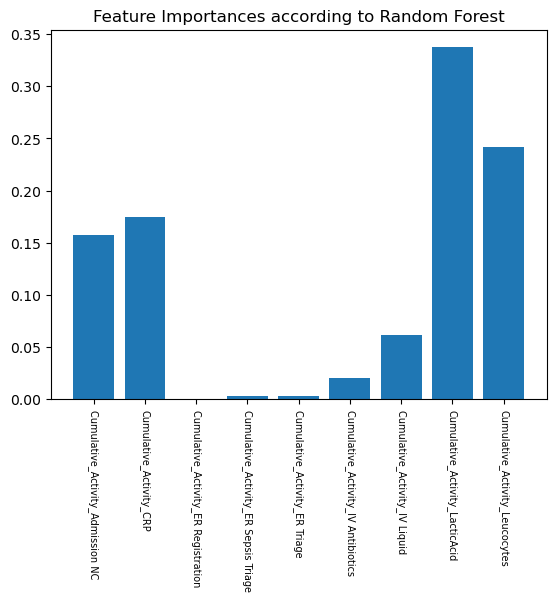

array([7.00823421, 6.981753  , 7.63345296, ..., 6.92171947, 7.04750494,
       5.71856866])

In [15]:
# B
df_onlyactiv = PreProcess(df, prevActivity=False)
df_onlyactiv = df_onlyactiv[["Activity", "Complete Timestamp", "Case ID", "remaining_time(days)"]]

data_Sepsis_ag_onlyactiv = agg_per_event_encoding(df_onlyactiv, column_Sepsis_CaseID, column_Sepsis_Activity, prevActivity=False) 

X_train_onlyactiv, X_test_onlyactiv, y_train_onlyactiv, y_test_onlyactiv = train_test_time_based_split(
    data_Sepsis_ag_onlyactiv, time_threshold, column_Sepsis_CaseID, 
    column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

AllRegressing(X_train_onlyactiv, y_train_onlyactiv, X_test_onlyactiv, y_test_onlyactiv)


c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 


Random Forest Regressor Performance:
Mean Squared Error (MSE): 53.4140
Root Mean Squared Error (RMSE): 7.3085
Mean Absolute Error (MAE): 4.7940
R-squared (R²): -0.1920
Train Mean Squared Error (MSE): 4.8436
Train Root Mean Squared Error (RMSE): 2.2008
Train Mean Absolute Error (MAE): 1.4930
Train R-squared (R²): 0.8676

Multi-Layer Perceptron (MLP) Regressor Performance:
Mean Squared Error (MSE): 48.0489
Root Mean Squared Error (RMSE): 6.9317
Mean Absolute Error (MAE): 4.6147
R-squared (R²): -0.0722
Train Mean Squared Error (MSE): 31.8771
Train Root Mean Squared Error (RMSE): 5.6460
Train Mean Absolute Error (MAE): 4.0289
Train R-squared (R²): 0.1289


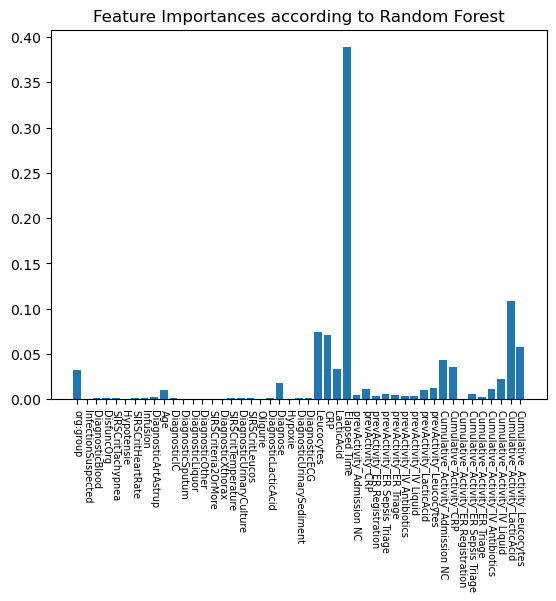

array([8.12138356, 7.71410935, 5.93720866, ..., 6.92355081, 7.84812069,
       6.56430936])

In [16]:
#C) Engineer a feature called elapsed time by computing the time elapsed since the case started until the current event,
#   and repeat Tasks 2 and 3. Evaluate if adding this feature (elapsed time) help improve the model performance.

df_elapsed_time = PreProcess(df)

group = df_elapsed_time.groupby(column_Sepsis_CaseID)
min_times = group['Complete Timestamp'].transform('min')
time_differences = df_elapsed_time['Complete Timestamp'] - min_times
seconds = time_differences.dt.total_seconds()
seconds_per_day = 86400
df_elapsed_time['Elapsed Time'] = seconds / seconds_per_day

data_Sepsis_ag_elapsed_time = agg_per_event_encoding(df_elapsed_time, column_Sepsis_CaseID, column_Sepsis_Activity) 

X_train_elapsed_time, X_test_elapsed_time, y_train_elapsed_time, y_test_elapsed_time = train_test_time_based_split(
   data_Sepsis_ag_elapsed_time, time_threshold, column_Sepsis_CaseID, 
   column_Sepsis_Activity, column_Sepsis_Timestamps, label_column)

AllRegressing(X_train_elapsed_time, y_train_elapsed_time, X_test_elapsed_time, y_test_elapsed_time)


## Task 6.  Report your results and discuss your findings

By now, you have trained and applied a regressor and evaluated its performance on 
(1) the non-bucketed training and test set with all possible prefix length. 
(2) three buckets of different prefix length. 
(3 & 4) and two other methods you tried (e.g., a different encoding or with additional features). 

You have created tables or figures which you can add to your report. 

Create an overview table or figure that compares the performance of each method on the data set, for example, see the table here below. 


Discuss your findings and reflect on the following questions in your report:
- According to the error measures, which one would you suggest as the optimal method (preprocessing + encoding + algorithm)? 
- Are there any discrepancies between the MAE, MSE, RMSE, and R^2 measures in terms of which model/method performs the best? If yes, how would you explain these discrepancies. 
- Which one of the MAE, MSE, RMSE, and R^2 would you use for selecting the model? Why?
- Which one of the encoding would you suggest for this data set? Why?
- Which features have a big influence on predicting the remaining time?





| Encoding | Model | Training MAE  | Test MAE |  Training MSE  |  Test MSE  | Training R^2 | Test R^2 |... |
|------|------|------|------|------|------|------|------|-----|
|  Agg-state and no bucketing |  RF regressor |  |  | || | |
|  Agg-state and prefix length 5 |RF regressor       |  |  | || | |
|   Agg-state and prefix length 10 |RF regressor     |  |  | || | |
|   Agg-state and prefix length 15 |RF regressor     |  |  | || | |
|   last-state |RF regressor    |  |  | || | |
|   last-state + additional features |RF regressor    |  |  | || | |












## Bonus Tasks 

We would like to challenge you with the following bonus tasks. For each task that is successfully completed, you may obtain max. 0.5 extra point added to the total 14 points. 

1. Train a MLP for regression. (If you have used MLP for Task 3, then train another regressor of interest. Evaluate the performance. Explain this in your report.)
2. Train an Autoencoder for feature reduction/learning and evaluate whether it helps improve the performance. Explain this in your report.

